In [3]:
import os
import pathlib
import tensorflow as tf
from tqdm import tqdm

def data_augmentation(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, 0.6, 1.4)
    img = tf.image.random_saturation(img, 0.6, 1.4)
    img = tf.image.random_hue(img, 0.2)
    return img

def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    return img / 255.0  # Normalize to [0,1]

def contrastive_loss(z_i, z_j):
    """
    Computes the contrastive loss between pairs of embeddings.
    Assumes positive pairs (augmentations of the same image) are provided as inputs.
    """
    distances = tf.sqrt(tf.reduce_sum(tf.square(z_i - z_j), axis=1))
    return tf.reduce_mean(distances)

# Constants
data_dir = pathlib.Path('png250px/')
BATCH_SIZE = 32
epochs = 50  # Example number of epochs

# Data Loading
list_ds = tf.data.Dataset.list_files(str(data_dir/'*.*'))
images_ds = list_ds.map(process_path).batch(BATCH_SIZE)

# Model Definition
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
x = base_model.output
x = tf.keras.layers.BatchNormalization()(x)
out = tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=out)

# Training Configuration
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # This will force TF to use CPU
optimizer = tf.keras.optimizers.legacy.Adam(1e-3)

# Training Loop
for epoch in tqdm(range(epochs), desc="Epochs"):
    for batch_imgs in images_ds:
        augmented_batch_1 = data_augmentation(batch_imgs)
        augmented_batch_2 = data_augmentation(batch_imgs)
        
        with tf.GradientTape() as tape:
            z_i = tf.math.l2_normalize(model(augmented_batch_1), axis=-1)
            z_j = tf.math.l2_normalize(model(augmented_batch_2), axis=-1)
            loss = contrastive_loss(z_i, z_j)
            
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))


Epochs: 100%|██████████| 50/50 [2:00:27<00:00, 144.55s/it]  


8/8 [==============================] - 7s 814ms/step


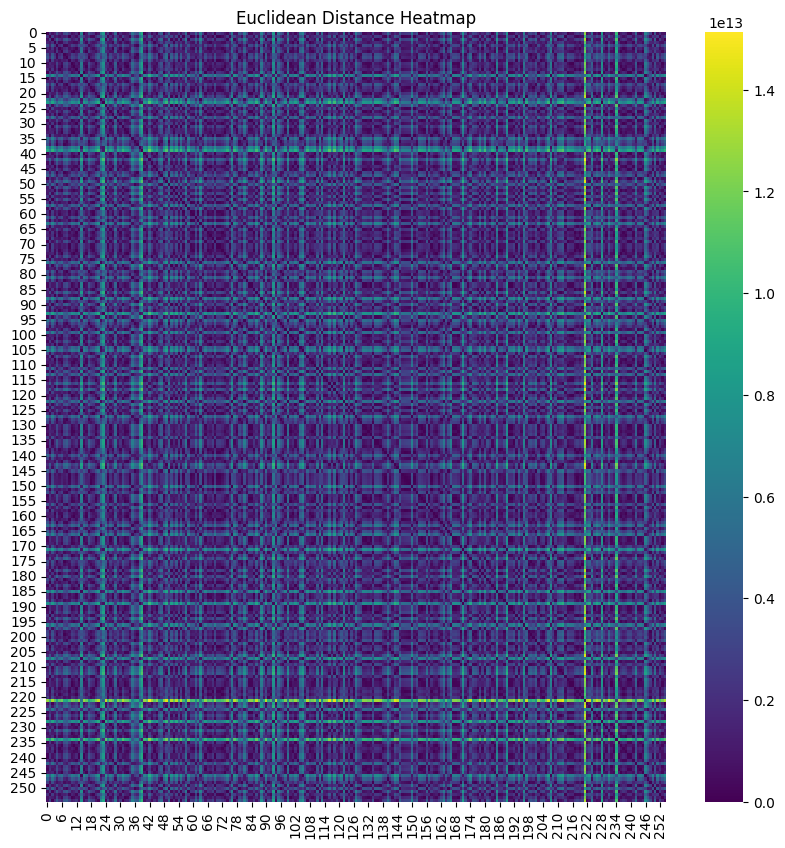

In [6]:
# Visualize with Heat Map
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def get_all_embeddings(model, dataset):
    """Get embeddings for all images in the dataset."""
    return model.predict(dataset)

def compute_distance_matrix(embeddings):
    """Compute the Euclidean distance matrix for the given embeddings."""
    num_images = embeddings.shape[0]
    distance_matrix = np.zeros((num_images, num_images))

    for i in range(num_images):
        for j in range(num_images):
            distance_matrix[i, j] = np.linalg.norm(embeddings[i] - embeddings[j])
    
    return distance_matrix

def plot_distance_heatmap(distance_matrix):
    """Plot the Euclidean distance heatmap."""
    plt.figure(figsize=(10, 10))
    sns.heatmap(distance_matrix, cmap='viridis')
    plt.title('Euclidean Distance Heatmap')
    plt.show()

# Process all images to obtain their embeddings
all_embeddings = get_all_embeddings(model, images_ds)

# Compute the distance matrix
distance_matrix = compute_distance_matrix(all_embeddings)

# Plot the distance heatmap
plot_distance_heatmap(distance_matrix)


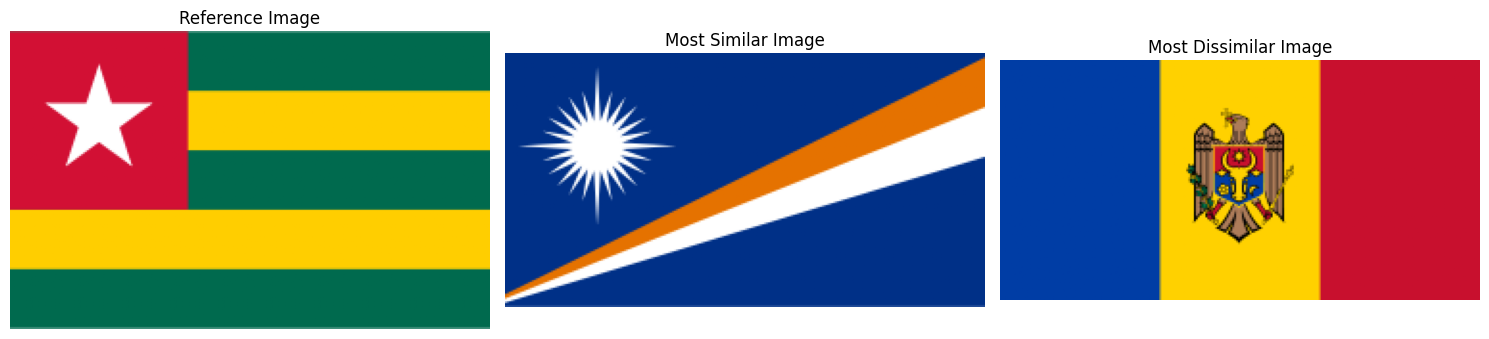

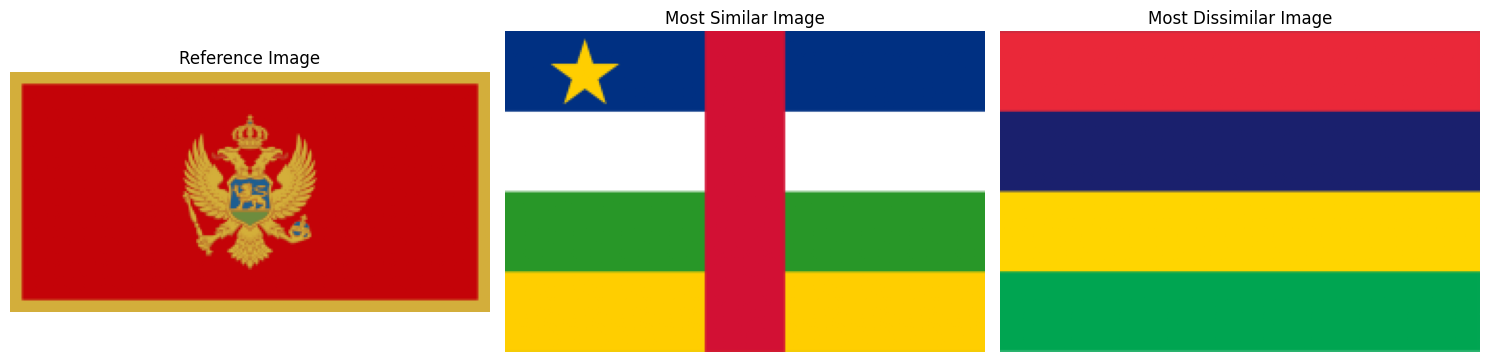

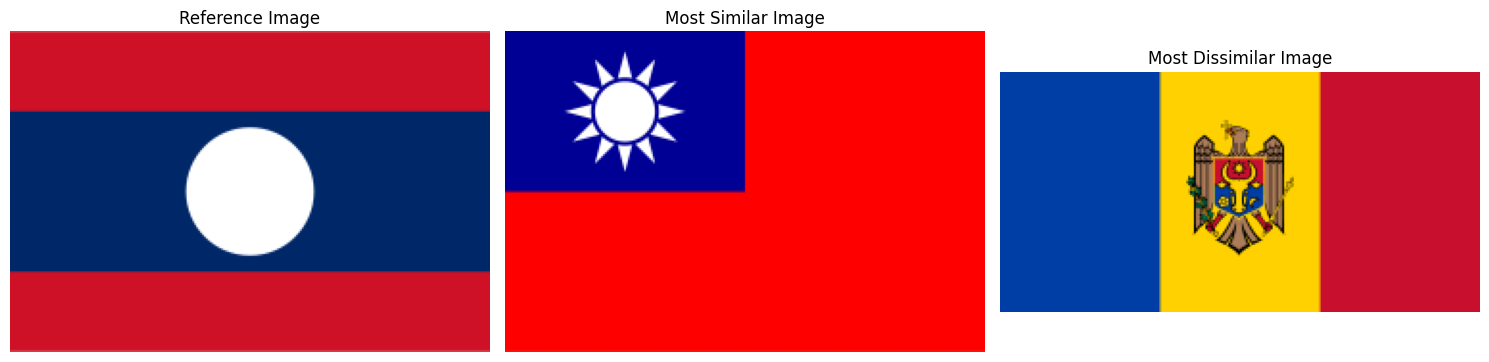

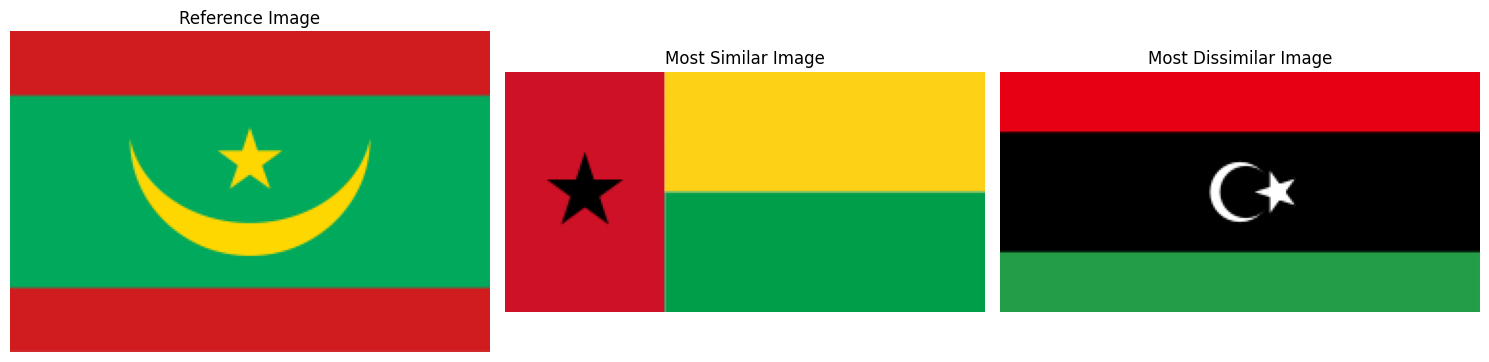

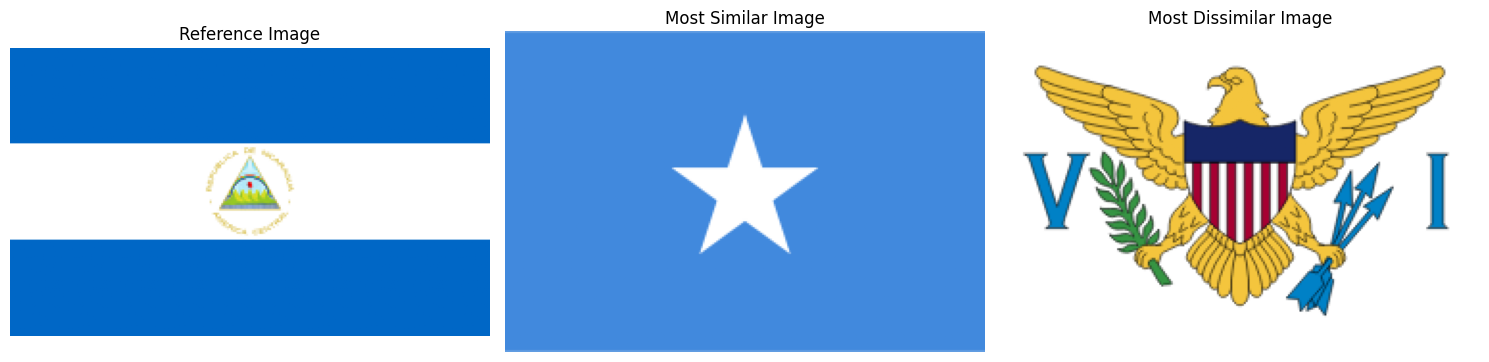

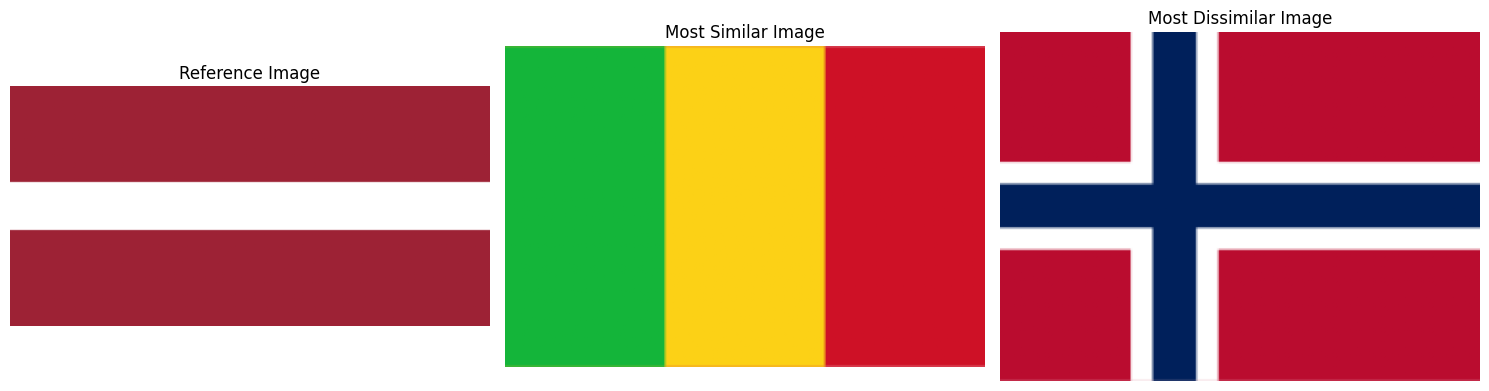

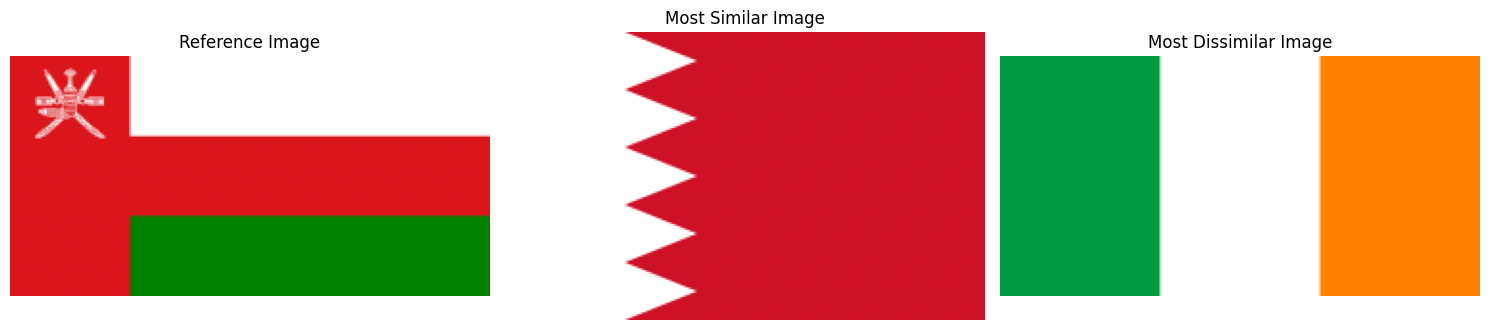

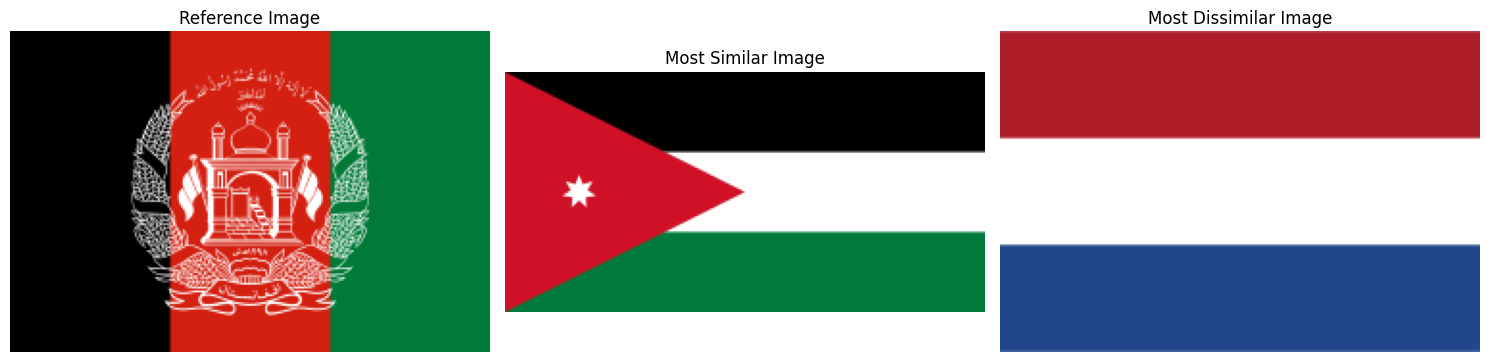

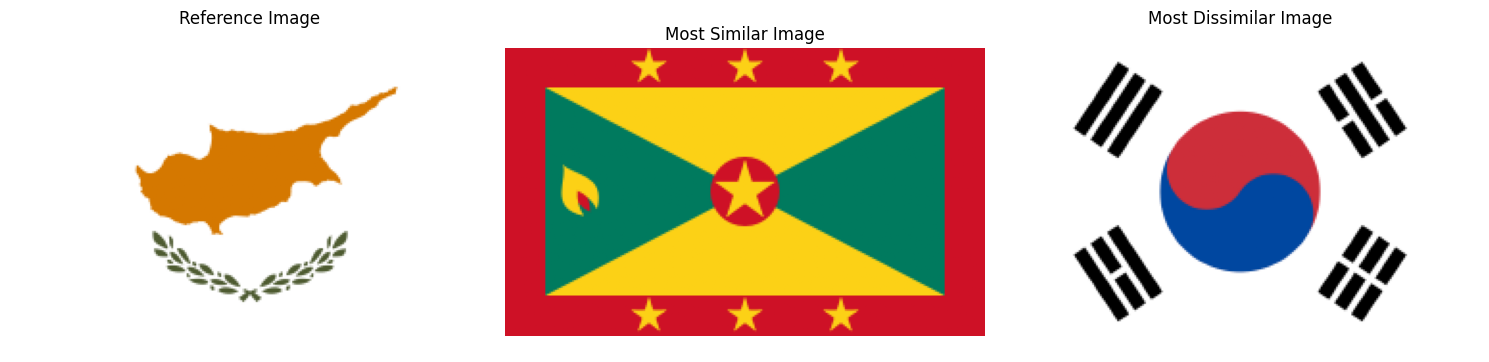

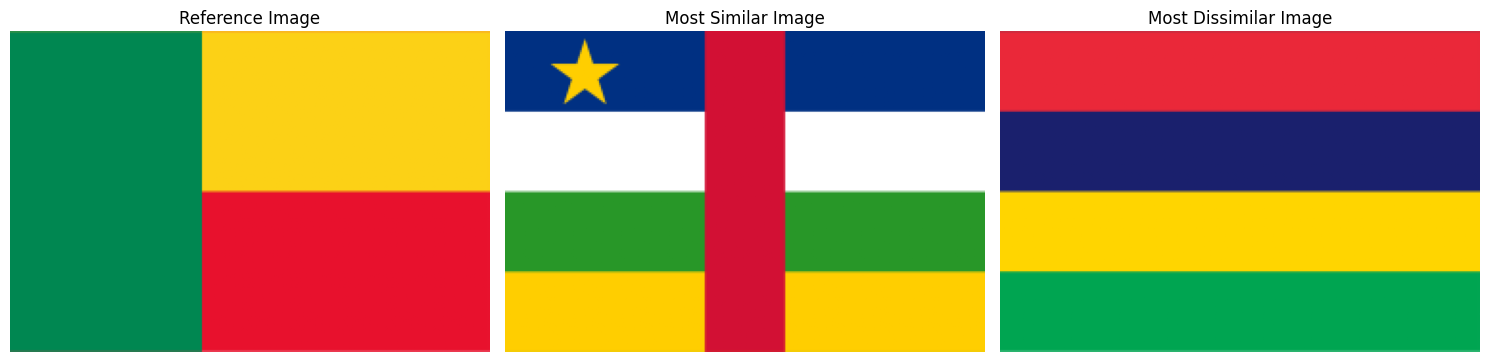

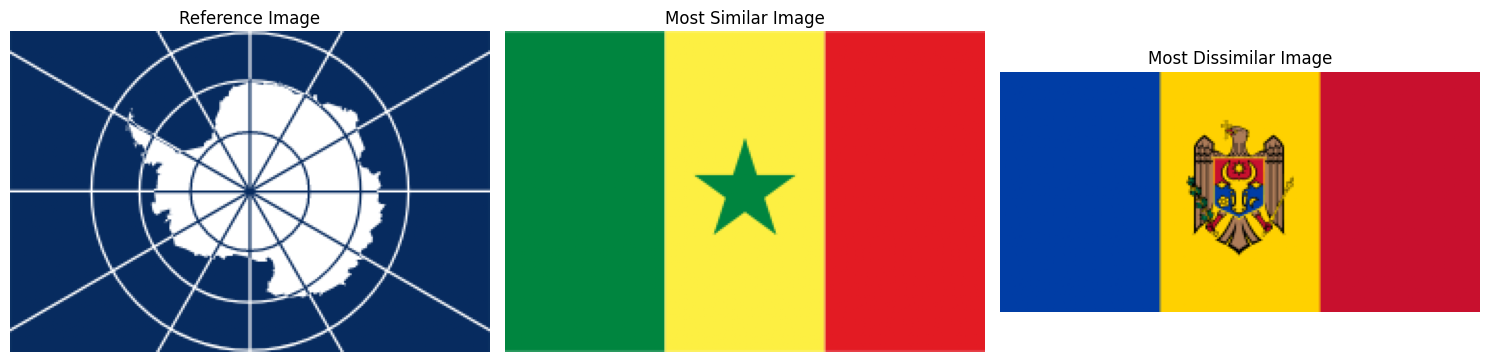

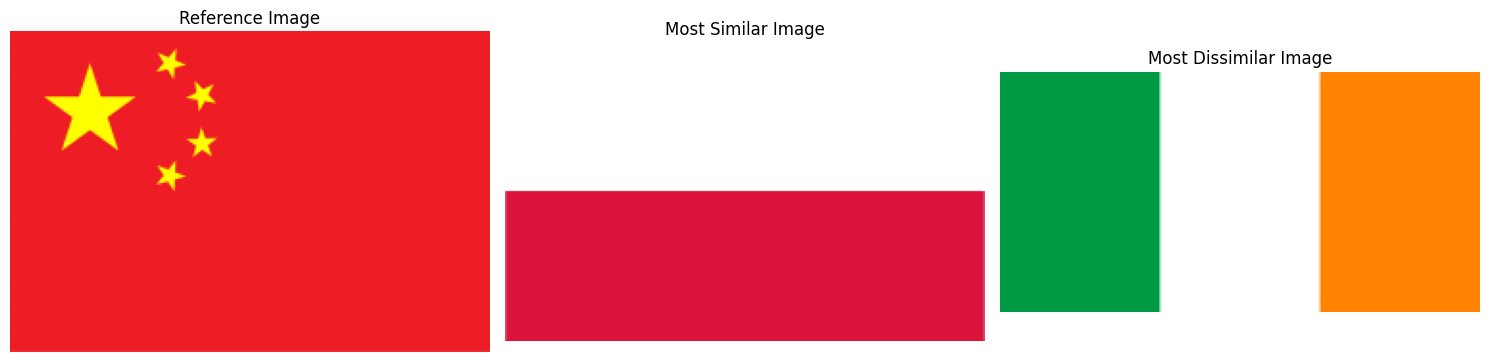

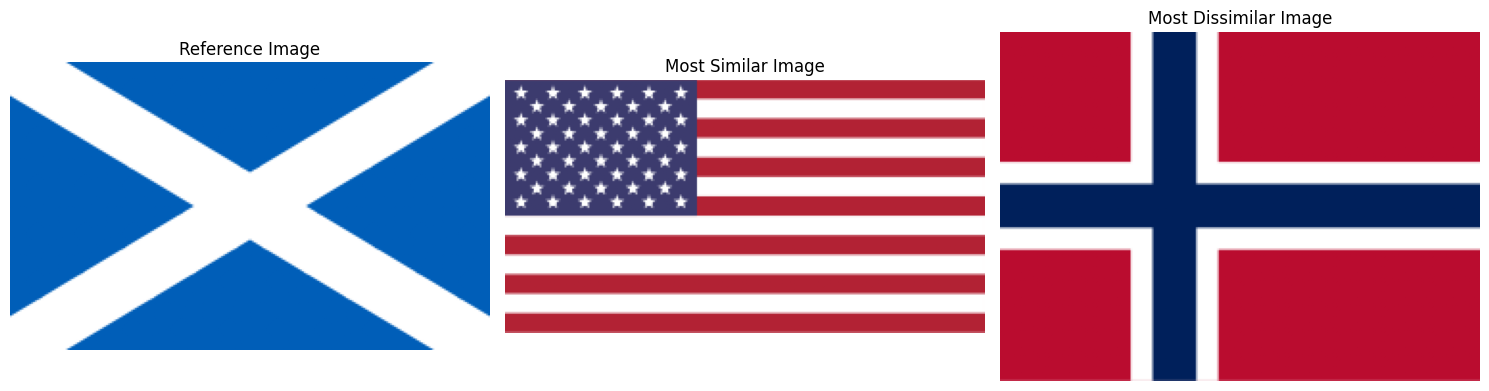

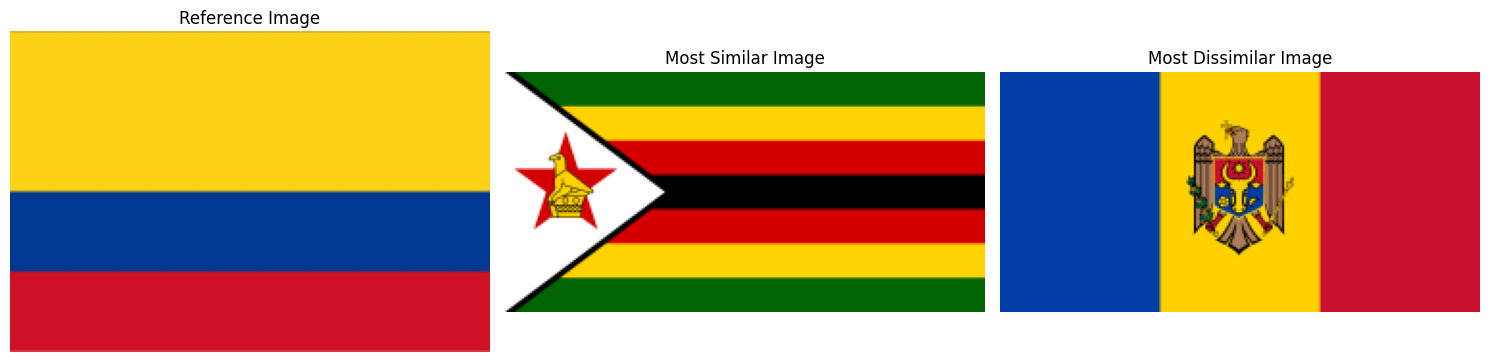

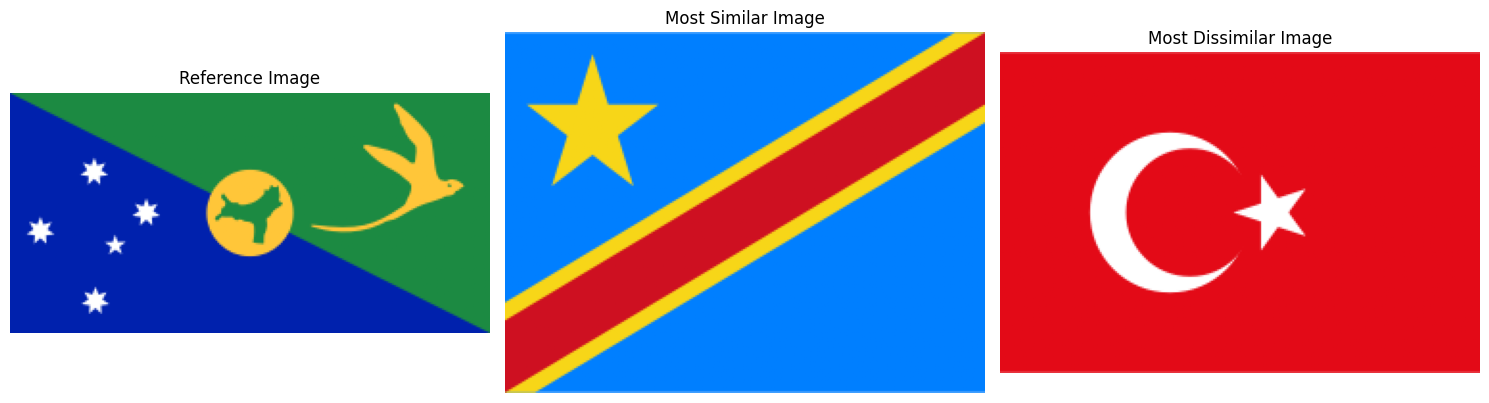

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def get_similar_and_dissimilar_indices(i, distance_matrix):
    """Get the indices of the most similar and most dissimilar images to image at index i."""
    image_distances = distance_matrix[i].copy()
    image_distances[i] = np.inf  # To ignore the distance with itself
    most_similar_index = np.argmin(image_distances)
    
    # Using original value for self-similarity, which is always 0
    image_distances[i] = 0
    sorted_indices = np.argsort(image_distances)
    # Get the index of the ith largest value. For instance, for the xth largest:
    most_dissimilar_index = sorted_indices[-48]


    return most_similar_index, most_dissimilar_index

def display_images(reference_path, similar_path, dissimilar_path):
    """Display three images side by side: reference, most similar, and most dissimilar."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    titles = ['Reference Image', 'Most Similar Image', 'Most Dissimilar Image']
    for ax, path, title in zip(axes, [reference_path, similar_path, dissimilar_path], titles):
        ax.imshow(plt.imread(path))
        ax.axis('off')
        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

def get_and_display_similar_and_dissimilar(i, distance_matrix, all_image_paths):
    """Get and display the most similar and most dissimilar images to image at index i."""
    similar_idx, dissimilar_idx = get_similar_and_dissimilar_indices(i, distance_matrix)
    display_images(all_image_paths[i], all_image_paths[similar_idx], all_image_paths[dissimilar_idx])
    return similar_idx, dissimilar_idx

all_image_paths = [str(p) for p in data_dir.glob('*.*')]
for i in range(15):
    get_and_display_similar_and_dissimilar(i, distance_matrix, all_image_paths)
